In [1]:
%pip install tensorflow-datasets==4.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.6.0
    Uninstalling tensorflow-datasets-4.6.0:
      Successfully uninstalled tensorflow-datasets-4.6.0


In [2]:
import datetime
import tensorflow as tf
import tensorflow_datasets as tfds 
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, Reshape, GlobalAveragePooling2D, MaxPooling2D, UpSampling2D

In [3]:
def preprocess(data):
    batch_size = 32
    buffer_size = 2000

    data = (
        data.map(lambda image, target: (tf.cast(image, tf.float32)/256, target))
            .map(lambda image, target: (image, image))
            .map(lambda image, target: (image + tf.random.normal(shape=(28,28,1), mean=0, stddev=0.1), target))
            .map(lambda image, target: (tf.clip_by_value(image, 0, 1), target))
    )
    
    data.cache()
    data = (
        data.shuffle(buffer_size)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
    )
    return data

In [39]:
def normalize(data, batch_size):
    batch_size = batch_size

    data = (
        data.map(lambda image: tf.cast(image, tf.float32)/256)
            .map(lambda image: tf.clip_by_value(image, 0, 1))
    )
    
    data.cache()
    data = (
        data.batch(batch_size)
    )
    print(data)
    return data

In [152]:
def visualize(img):
  plt.imshow(img)       
  plt.show()



(28, 28)


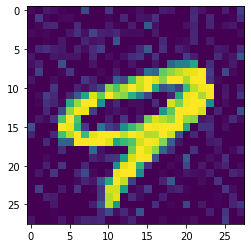

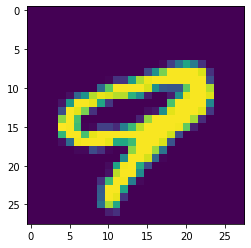

In [15]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
preprocessed_train_ds = preprocess(train_ds)
preprocessed_test_ds = preprocess(test_ds)

for image, target in preprocessed_train_ds.take(1):
    visualize(tf.squeeze(image[0], axis=-1))
    visualize(tf.squeeze(target[0], axis=-1))

# Encoder


In [16]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(64, 3, activation='relu', padding='same') # 28*28*64
    self.pooling1 = MaxPooling2D(2) # 14*14*64
    self.conv3 = Conv2D(32, 3, activation='relu', padding='same') # 14*14*32
    self.pooling2 = MaxPooling2D(2) # 7*7*32
    self.conv5 = Conv2D(16, 3, activation='relu', padding='same') # 7*7*16
    self.globalpooling = GlobalAveragePooling2D() # 16
    self.out = Dense(10, activation="relu")


  @tf.function
  def __call__(self, x, training=False):
    x = self.conv1(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.pooling2(x)
    x = self.conv5(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(49, activation="relu")
        self.reshape = Reshape((7, 7, 1))
        self.conv1 = Conv2D(16, 3, activation="relu", padding="same")
        self.upsampling1 = UpSampling2D(2)
        self.conv2 = Conv2D(32, 3, activation="relu", padding="same")
        self.upsampling2 = UpSampling2D(2)
        self.conv_output = Conv2D(1, 3, activation="sigmoid", padding="same")

    @tf.function
    def __call__(self, x, training=False):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.upsampling1(x)
        x = self.conv2(x)
        x = self.upsampling2(x)
        x = self.conv_output(x)
        return x

In [134]:
class Autoencoder(tf.keras.Model):
  def __init__(self, optimizer, loss_function):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()

    self.metrics_list = [
      tf.keras.metrics.Mean(name="loss")]

    self.optimizer = optimizer
    self.loss_function = loss_function

  @property
  def metrics(self):
    return self.metrics_list
  
  def get_encoder(self):
    return self.enc
   
  def get_decoder(self):
    return self.dec
    
  def reset_metrics(self):
     for metric in self.metrics:
        metric.reset_state()

  def call(self, input, training=False):
    embedding = self.enc(input)
    output = self.dec(embedding)
    return output

  @tf.function
  def train_step(self, data):
    image, target = data
    with tf.GradientTape() as tape: 
      prediction = self(image, training = True)
      loss = self.loss_function(target, prediction)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
    self.metrics[0].update_state(loss)  
    return gradients

  @tf.function
  def test_step(self, data):
    image, target = data
    prediction = self(image, training = False)
    loss = self.loss_function(target, prediction)
    self.metrics[0].update_state(loss)
    return prediction, target

    

In [150]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0, leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in tqdm(test_ds, position=0, leave=True):
            prediction, target = model.test_step(data)

        visualize(tf.squeeze(prediction[0], axis = -1))
        visualize(tf.squeeze(target[0], axis = -1))


        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)

        print("Loss: ", model.metrics[0].result().numpy(), "(Test)")

100%|██████████| 1875/1875 [04:27<00:00,  7.00it/s]


Epoch:  1
Loss:  0.07642618 (Train)


100%|██████████| 313/313 [00:10<00:00, 30.60it/s]


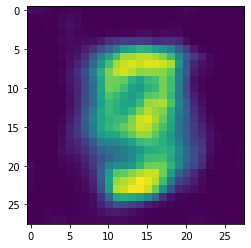

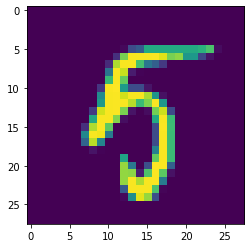

Loss:  0.05262016 (Test)


100%|██████████| 1875/1875 [04:24<00:00,  7.09it/s]


Epoch:  2
Loss:  0.047807734 (Train)


100%|██████████| 313/313 [00:09<00:00, 31.61it/s]


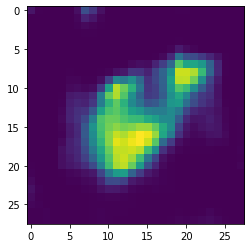

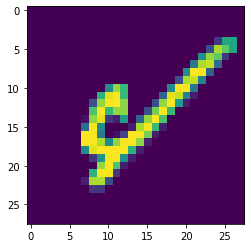

Loss:  0.044239756 (Test)


100%|██████████| 1875/1875 [04:21<00:00,  7.16it/s]


Epoch:  3
Loss:  0.04281527 (Train)


100%|██████████| 313/313 [00:09<00:00, 31.58it/s]


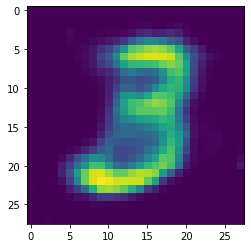

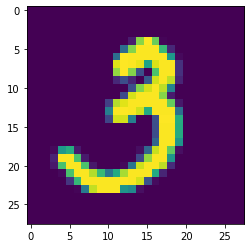

Loss:  0.04131319 (Test)


100%|██████████| 1875/1875 [04:23<00:00,  7.11it/s]


Epoch:  4
Loss:  0.040869966 (Train)


100%|██████████| 313/313 [00:09<00:00, 31.48it/s]


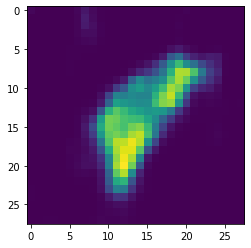

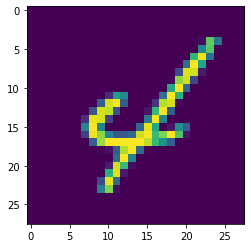

Loss:  0.040233772 (Test)


100%|██████████| 1875/1875 [04:27<00:00,  7.00it/s]


Epoch:  5
Loss:  0.039771847 (Train)


100%|██████████| 313/313 [00:09<00:00, 31.63it/s]


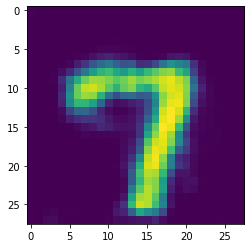

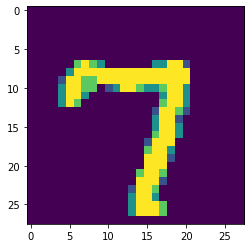

Loss:  0.03905713 (Test)


In [187]:
batch_size = 32
epochs = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.MeanSquaredError()

autoencoder = Autoencoder(optimizer=optimizer, loss_function=loss_function)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(autoencoder, preprocessed_train_ds, preprocessed_test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

# Latent Space Analysis

In [188]:
import numpy as np
from sklearn.manifold import TSNE

batch_size = 1000

encoder = autoencoder.get_encoder()

images = [image for image, label in test_ds.take(1000)]
labels = [label for image, label in test_ds.take(1000)]

images = tf.convert_to_tensor(images)
images = tf.data.Dataset.from_tensor_slices(images)
print(images)
images = normalize(images, batch_size=batch_size) 
print(images)
print(labels)

#images = np.array(images).reshape(-1, 28, 28, 1)
#images = tf.convert_to_tensor(images)
for batch in images:
  embeddings = encoder(batch)
  embeddings_2d = (TSNE(n_components=2).fit_transform(embeddings))
print(embeddings_2d)  


<TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>
[<tf.Tensor: shape=(), dtype=int64, numpy=2>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=4>, <tf.Tensor: shape=(), dtype=int64, numpy=8>, <tf.Tensor: shape=(), dtype=int64, numpy=7>, <tf.Tensor: shape=(), dtype=int64, numpy=6>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=6>, <tf.Tensor: shape=(), dtype=int64, numpy=3>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=8>, <tf.Tensor: shape=(), dtype=int64, numpy=0>, <tf.Tensor: shape=(), dtype=int64, numpy=7>, <tf.Tensor: shape=(), dtype=int64, numpy=9>, <tf.Tensor: shape=(), dtype=int64, numpy=8>, <tf.Tensor: shape=(), dtype=int64, numpy=4>, <t

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[  6.1408224 -24.893677 ]
 [ 26.660923  -32.76834  ]
 [-20.385736  -18.760532 ]
 ...
 [  8.872548   17.63428  ]
 [-26.775232   -4.7858963]
 [ -4.5831923  38.819714 ]]


<bound method NDFrame.head of              0          1  labels
0     6.140822 -24.893677       2
1    26.660923 -32.768341       0
2   -20.385736 -18.760532       4
3    -9.211736  15.221277       8
4   -31.911772  -0.431331       7
..         ...        ...     ...
995   3.678224   0.344861       8
996 -17.435675  33.619019       1
997   8.872548  17.634279       6
998 -26.775232  -4.785896       7
999  -4.583192  38.819714       1

[1000 rows x 3 columns]>


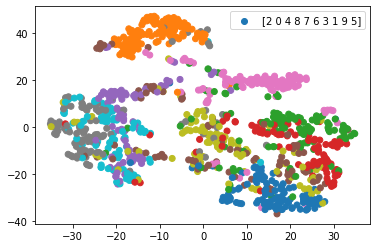

In [189]:
import pandas as pd
labels = [label for image, label in test_ds.take(1000)]

labels = np.asarray(labels, dtype=int)

data = pd.DataFrame(data = (embeddings_2d[:,0], embeddings_2d[:,1]))
data = data.T
data["labels"] = labels
print(data.head)
plt.scatter(data[:][0], data[:][1], c=data[:]["labels"], label=data[:]["labels"].unique(), cmap="tab10", )
plt.axis()
plt.legend()

plt.show()


# Interpolation


targets


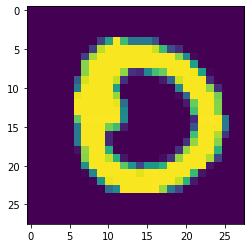

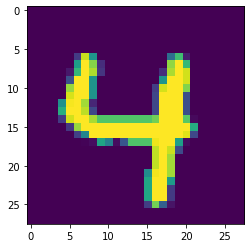

interpolated reconstructions


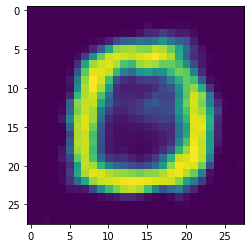

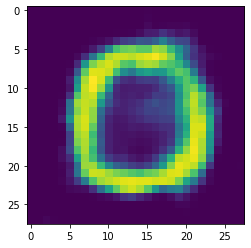

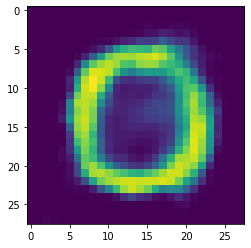

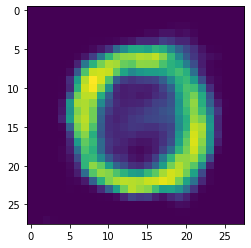

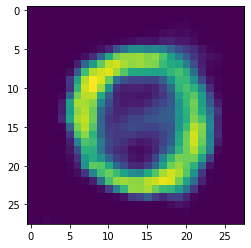

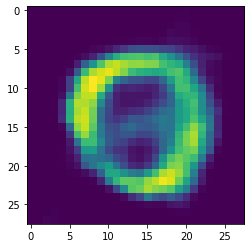

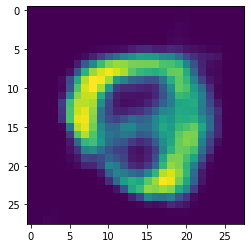

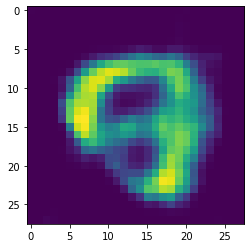

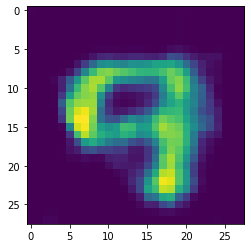

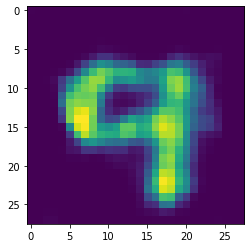

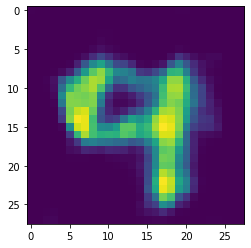

In [198]:
image1 = embeddings[1]
image2 = embeddings[2]


spaces = np.linspace(0,1,11)
in_betweens = []
for x in spaces:
  in_betweens.append(image1 + x *(image2-image1))
in_betweens = tf.convert_to_tensor(in_betweens)

decoder = autoencoder.get_decoder()

print("targets")
for image in images:
  visualize(tf.squeeze(image[1]))
  visualize(tf.squeeze(image[2]))


print("interpolated reconstructions")
for in_between in in_betweens:
  reconstruction = decoder(tf.expand_dims(in_between, axis=0))
  visualize(tf.squeeze(reconstruction))

